In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import networkx as nx
from rdkit.Chem import rdmolops
import torch
import pandas as pd

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from rdkit.Chem import AllChem

In [2]:
# Verificar disponibilidad de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Cargar el dataset
ruta_archivo_bioactivity = 'bioactivity_data_2class_pIC50.csv'

# Lee el archivo CSV en un DataFrame
df = pd.read_csv(ruta_archivo_bioactivity)

# Mostrar que se haya importado correctamente el archivo
df

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL2022564,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.1124,2.0,10.0,9.494850
1,CHEMBL3234200,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,814.103,4.8664,2.0,10.0,9.522879
2,CHEMBL3234201,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,842.157,5.5025,2.0,10.0,9.327902
3,CHEMBL3234202,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.1124,2.0,10.0,9.920819
4,CHEMBL3649592,CC1CCC(NCc2ccn(Cc3ccccc3)c(=O)c2O)CC1,inactive,326.440,3.2705,2.0,4.0,4.562249
...,...,...,...,...,...,...,...,...
10630,CHEMBL4636800,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NCCCN(C)C)nc2...,intermediate,446.555,4.0263,2.0,8.0,5.102373
10631,CHEMBL4644274,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)N(...,active,514.674,5.7260,2.0,8.0,6.004365
10632,CHEMBL4636056,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,intermediate,579.749,5.3221,2.0,8.0,5.886057
10633,CHEMBL4643578,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,active,624.790,5.2330,2.0,9.0,6.050610


CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(C)(C)C)C[C@@H](C)C[C@H](O)[C@H](C)C2=N[C@@H](CCC(=O)N[C@@H](Cc3ccc(OC)cc3)C(=O)N(C)[C@@H](C)C(=O)N1C)CS2


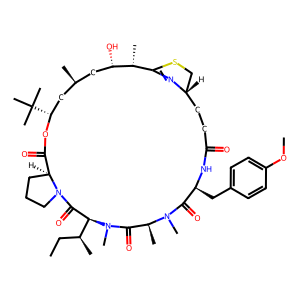

In [4]:
# Convertir SMILES a Mol
smile = df["canonical_smiles"][0]
mol = Chem.MolFromSmiles(smile)

print(Chem.MolToSmiles(mol))

# Dibujar la molécula
Draw.MolToImage(mol)

In [5]:
# Función para convertir SMILES a grafo
def mol_to_nx(smiles):
    mol = Chem.MolFromSmiles(smiles)
    G = nx.Graph()
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), label=atom.GetSymbol(), atomic_num=atom.GetAtomicNum())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), label=bond.GetBondType())
    return G

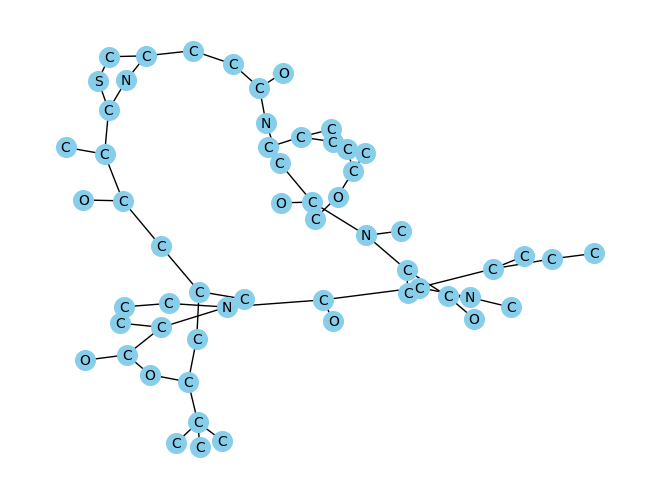

In [6]:
# Generamos un nuevo grafo para esa molécula
G = mol_to_nx(smile)

# Visualizar el grafo
pos = nx.spring_layout(G)
labels = nx.get_node_attributes(G, 'label')
nx.draw(G, pos, labels=labels, with_labels=True, node_size=200, node_color='skyblue', font_size=10, font_color='black')
plt.show()

In [7]:
# Función para triangular el grafo (hacerlo chordal)
def make_chordal(G):
    chordal_G = nx.Graph(G)
    cliques = list(nx.find_cliques(G))
    for clique in cliques:
        for i in range(len(clique)):
            for j in range(i + 1, len(clique)):
                if not chordal_G.has_edge(clique[i], clique[j]):
                    chordal_G.add_edge(clique[i], clique[j])
    return chordal_G

In [8]:
# Función para construir el Junction Tree
def build_junction_tree(chordal_G):
    cliques = list(nx.find_cliques(chordal_G))
    JG = nx.Graph()
    for i, clique in enumerate(cliques):
        JG.add_node(i, atoms=clique, label='Clique {}'.format(i))
    for i in range(len(cliques)):
        for j in range(i + 1, len(cliques)):
            common_atoms = set(cliques[i]).intersection(set(cliques[j]))
            if common_atoms:
                JG.add_edge(i, j, weight=len(common_atoms))
    return JG

In [9]:
# Función auxiliar para construir el Junction Tree a partir del grafo molecular
def graph_to_junction_tree(graph):
    chordal_G = make_chordal(graph)
    junction_tree = build_junction_tree(chordal_G)
    return junction_tree

In [10]:
def pad_tensor(tensor, max_length):
    """
    Rellena el tensor con ceros hasta alcanzar max_length en ambas dimensiones.
    """
    padded_tensor = torch.zeros((max_length, max_length), dtype=torch.float32)
    tensor = torch.tensor(tensor, dtype=torch.float32)  # Convertir numpy array a torch tensor
    padded_tensor[:tensor.shape[0], :tensor.shape[1]] = tensor
    return padded_tensor

def pad_labels(labels, max_length):
    """
    Rellena el tensor de etiquetas con ceros hasta alcanzar max_length.
    """
    padded_labels = torch.zeros(max_length, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)  # Convertir numpy array a torch tensor
    padded_labels[:len(labels)] = labels
    return padded_labels

In [11]:
# Convertir SMILES a grafos y almacenar en una nueva columna "graphs"
df["graphs"] = df["canonical_smiles"].apply(mol_to_nx)
df

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,graphs
0,CHEMBL2022564,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.1124,2.0,10.0,9.494850,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,CHEMBL3234200,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,814.103,4.8664,2.0,10.0,9.522879,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,CHEMBL3234201,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,842.157,5.5025,2.0,10.0,9.327902,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,CHEMBL3234202,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.1124,2.0,10.0,9.920819,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,CHEMBL3649592,CC1CCC(NCc2ccn(Cc3ccccc3)c(=O)c2O)CC1,inactive,326.440,3.2705,2.0,4.0,4.562249,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
...,...,...,...,...,...,...,...,...,...
10630,CHEMBL4636800,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NCCCN(C)C)nc2...,intermediate,446.555,4.0263,2.0,8.0,5.102373,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
10631,CHEMBL4644274,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)N(...,active,514.674,5.7260,2.0,8.0,6.004365,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
10632,CHEMBL4636056,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,intermediate,579.749,5.3221,2.0,8.0,5.886057,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
10633,CHEMBL4643578,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,active,624.790,5.2330,2.0,9.0,6.050610,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [12]:
# Aplicar la función graph_to_junction_tree a cada grafo y almacenar los Junction Trees en una nueva columna "junction_trees"
df["junction_trees"] = df["graphs"].apply(graph_to_junction_tree)
df

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50,graphs,junction_trees
0,CHEMBL2022564,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.1124,2.0,10.0,9.494850,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,CHEMBL3234200,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,814.103,4.8664,2.0,10.0,9.522879,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,CHEMBL3234201,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,842.157,5.5025,2.0,10.0,9.327902,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,CHEMBL3234202,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)O[C@H](C(...,active,828.130,5.1124,2.0,10.0,9.920819,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,CHEMBL3649592,CC1CCC(NCc2ccn(Cc3ccccc3)c(=O)c2O)CC1,inactive,326.440,3.2705,2.0,4.0,4.562249,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
...,...,...,...,...,...,...,...,...,...,...
10630,CHEMBL4636800,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NCCCN(C)C)nc2...,intermediate,446.555,4.0263,2.0,8.0,5.102373,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
10631,CHEMBL4644274,COc1ccc(-c2cnn3c(N)c(-c4ccccc4)c(NC4CC(C)(C)N(...,active,514.674,5.7260,2.0,8.0,6.004365,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
10632,CHEMBL4636056,CN1C(C)(C)CC(Nc2nc3c(-c4ccc(C(=O)N5C[C@@H]6C[C...,intermediate,579.749,5.3221,2.0,8.0,5.886057,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
10633,CHEMBL4643578,COC(=O)N1CCN(C(=O)c2ccc(-c3cnn4c(N)c(-c5ccccc5...,active,624.790,5.2330,2.0,9.0,6.050610,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


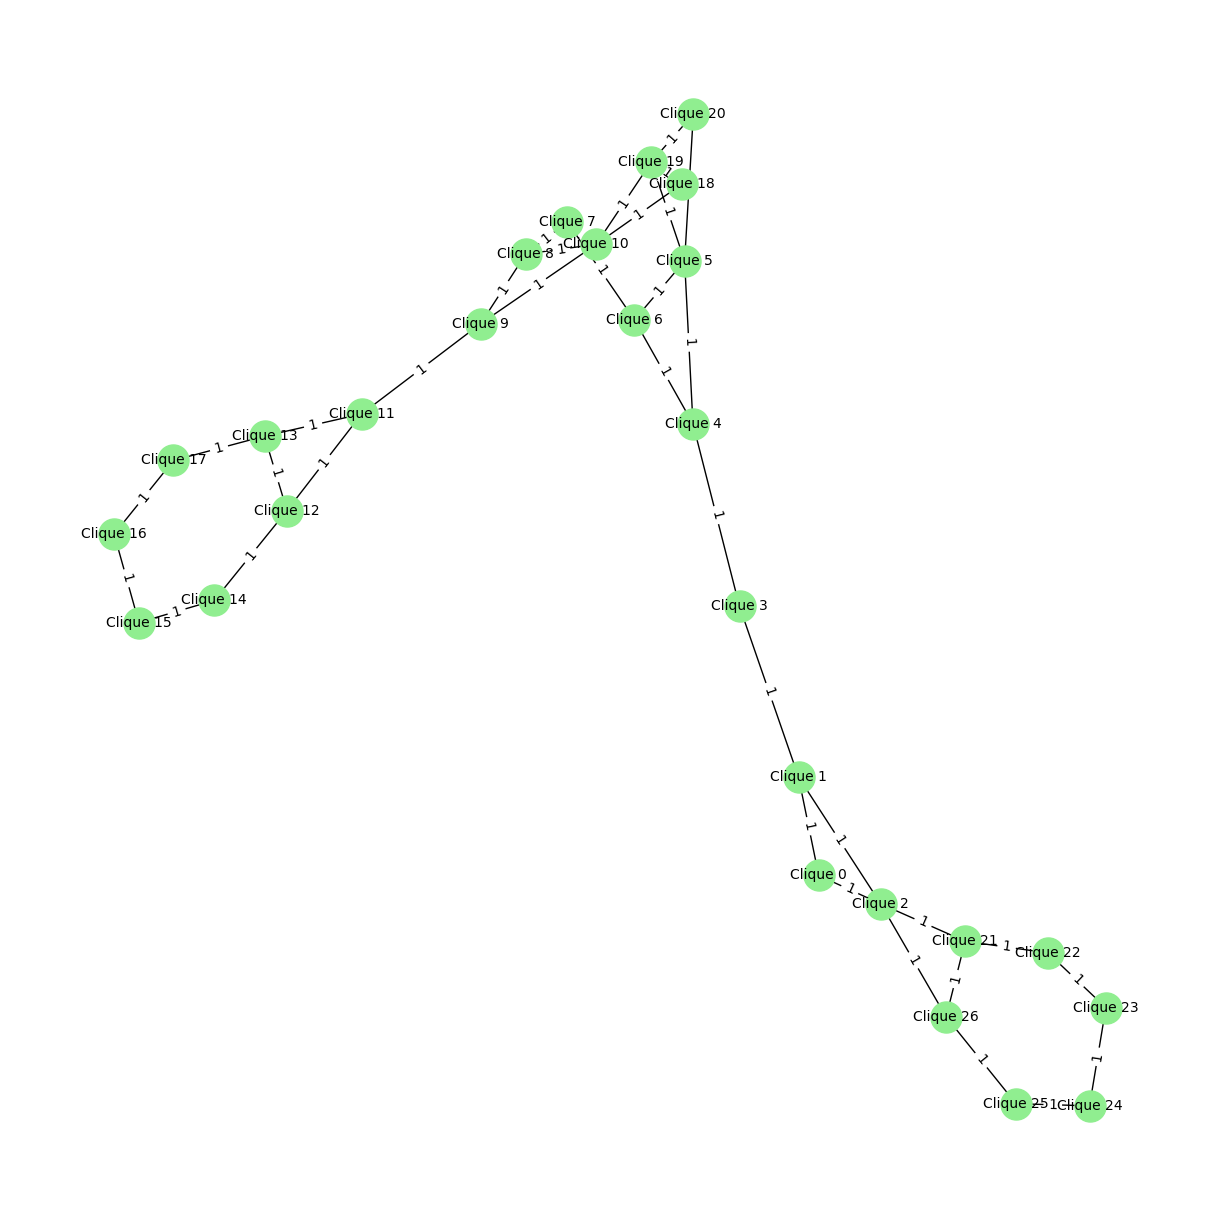

In [13]:
junction_tree = df["junction_trees"][6]
# Visualizar el Junction Tree
plt.figure(figsize=(12, 12))  # Aumentar el tamaño de la figura
pos = nx.spring_layout(junction_tree, k=0.15)
labels = nx.get_node_attributes(junction_tree, 'label')
nx.draw(junction_tree, pos, labels=labels, with_labels=True, node_size=500, node_color='lightgreen', font_size=10, font_color='black')
edge_labels = nx.get_edge_attributes(junction_tree, 'weight')
nx.draw_networkx_edge_labels(junction_tree, pos, edge_labels=edge_labels)
plt.show()

In [14]:
# Convertir SMILES a Mol
smile = df["canonical_smiles"][6]

# Crear el grafo molecular a partir del SMILES
G_Test = mol_to_nx(smile)

# Verificar los datos de los nodos
for node, data in G_Test.nodes(data=True):
    print(node, data)

0 {'label': 'C', 'atomic_num': 6}
1 {'label': 'C', 'atomic_num': 6}
2 {'label': 'N', 'atomic_num': 7}
3 {'label': 'C', 'atomic_num': 6}
4 {'label': 'C', 'atomic_num': 6}
5 {'label': 'C', 'atomic_num': 6}
6 {'label': 'C', 'atomic_num': 6}
7 {'label': 'N', 'atomic_num': 7}
8 {'label': 'C', 'atomic_num': 6}
9 {'label': 'C', 'atomic_num': 6}
10 {'label': 'C', 'atomic_num': 6}
11 {'label': 'C', 'atomic_num': 6}
12 {'label': 'C', 'atomic_num': 6}
13 {'label': 'C', 'atomic_num': 6}
14 {'label': 'C', 'atomic_num': 6}
15 {'label': 'C', 'atomic_num': 6}
16 {'label': 'O', 'atomic_num': 8}
17 {'label': 'C', 'atomic_num': 6}
18 {'label': 'O', 'atomic_num': 8}
19 {'label': 'C', 'atomic_num': 6}
20 {'label': 'C', 'atomic_num': 6}
21 {'label': 'C', 'atomic_num': 6}
22 {'label': 'C', 'atomic_num': 6}
23 {'label': 'C', 'atomic_num': 6}
24 {'label': 'C', 'atomic_num': 6}


In [15]:
def graph_to_tensor(graph, is_junction_tree=False):
    # Convertir el grafo en una matriz de adyacencia
    adj_matrix = nx.to_numpy_array(graph)

    if is_junction_tree:
        # Usar identificadores simples para los cliques en el Junction Tree
        node_labels = list(graph.nodes())
    else:
        # Obtener los números atómicos de los nodos
        node_labels = [data['atomic_num'] for _, data in graph.nodes(data=True)]

    return torch.tensor(adj_matrix, dtype=torch.float32), torch.tensor(node_labels, dtype=torch.long)

# Convertir el grafo molecular a tensor
mol_tensor, mol_labels = graph_to_tensor(G_Test)

# Convertir el Junction Tree a tensor
jt_tensor, jt_labels = graph_to_tensor(junction_tree, is_junction_tree=True)

print("Molecular Graph Tensor Shape:", mol_tensor.shape)
print("Molecular Graph Node Labels:", mol_labels)
print("Junction Tree Tensor Shape:", jt_tensor.shape)
print("Junction Tree Node Labels:", jt_labels)


Molecular Graph Tensor Shape: torch.Size([25, 25])
Molecular Graph Node Labels: tensor([6, 6, 7, 6, 6, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 8, 6, 8, 6, 6, 6, 6, 6,
        6])
Junction Tree Tensor Shape: torch.Size([27, 27])
Junction Tree Node Labels: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26])


In [16]:
# Determinar el tamaño máximo de los tensores
max_mol_dim = max(len(G) for G in df["graphs"])
max_jt_dim = max(len(JT) for JT in df["junction_trees"])

# Aplicar padding a los grafos moleculares y Junction Trees
df["padded_mol_tensors"] = df["graphs"].apply(lambda G: pad_tensor(nx.to_numpy_array(G), max_mol_dim))
df["padded_mol_labels"] = df["graphs"].apply(lambda G: pad_labels([data['atomic_num'] for _, data in G.nodes(data=True)], max_mol_dim))

df["padded_jt_tensors"] = df["junction_trees"].apply(lambda JT: pad_tensor(nx.to_numpy_array(JT), max_jt_dim))
df["padded_jt_labels"] = df["junction_trees"].apply(lambda JT: pad_labels(list(JT.nodes()), max_jt_dim))

In [17]:
print("Max mol dim: ", max_mol_dim)
print("Max jt dim: ", max_jt_dim)

Max mol dim:  145
Max jt dim:  152




---

Crear conjuntos de Entrenamiento y Pruebna


In [18]:
# Dividir el DataFrame en entrenamiento y prueba (80% entrenamiento, 20% prueba)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mean = self.fc2_mean(h)
        logvar = self.fc2_logvar(h)
        return mean, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim * 2, hidden_dim)  # Ajustar la entrada para latente concatenada
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_reconstructed = torch.sigmoid(self.fc2(h))
        return x_reconstructed

In [20]:
class JT_VAE(nn.Module):
    def __init__(self, mol_dim, jt_dim, hidden_dim, latent_dim):
        super(JT_VAE, self).__init__()
        self.mol_encoder = Encoder(mol_dim, hidden_dim, latent_dim)
        self.jt_encoder = Encoder(jt_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, mol_dim + jt_dim)  # Ajustar la dimensión de entrada de acuerdo al latente concatenado

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, mol_tensor, jt_tensor):
        mol_mean, mol_logvar = self.mol_encoder(mol_tensor)
        jt_mean, jt_logvar = self.jt_encoder(jt_tensor)

        mol_z = self.reparameterize(mol_mean, mol_logvar)
        jt_z = self.reparameterize(jt_mean, jt_logvar)

        # Aplicar mean pooling para asegurar dimensiones consistentes
        mol_z = mol_z.mean(dim=1)
        jt_z = jt_z.mean(dim=1)

        z = torch.cat((mol_z, jt_z), dim=1)

        reconstructed = self.decoder(z)
        return reconstructed, mol_mean, mol_logvar, jt_mean, jt_logvar

In [21]:
def loss_function(reconstructed, mol_tensor, jt_tensor, mol_mean, mol_logvar, jt_mean, jt_logvar):
    # Redimensionar los tensores para que coincidan antes de concatenarlos
    mol_tensor = mol_tensor.mean(dim=1)
    jt_tensor = jt_tensor.mean(dim=1)
    target = torch.cat((mol_tensor, jt_tensor), dim=1)

    BCE = F.binary_cross_entropy(reconstructed, target, reduction='sum')
    KLD = -0.5 * torch.sum(1 + mol_logvar - mol_mean.pow(2) - mol_logvar.exp()) \
          -0.5 * torch.sum(1 + jt_logvar - jt_mean.pow(2) - jt_logvar.exp())
    return BCE + KLD

In [22]:
# Continuar con el mismo proceso de entrenamiento
def train(model, dataloader, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for mol_tensor, jt_tensor in dataloader:
            mol_tensor = mol_tensor.to(device)
            jt_tensor = jt_tensor.to(device)
            optimizer.zero_grad()
            reconstructed, mol_mean, mol_logvar, jt_mean, jt_logvar = model(mol_tensor, jt_tensor)
            loss = loss_function(reconstructed, mol_tensor, jt_tensor, mol_mean, mol_logvar, jt_mean, jt_logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataloader.dataset)}')

In [23]:
# Crear un DataLoader con los datos del DataFrame
class MolJTDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.mol_tensors = list(df['padded_mol_tensors'].values)
        self.jt_tensors = list(df['padded_jt_tensors'].values)

    def __len__(self):
        return len(self.mol_tensors)

    def __getitem__(self, idx):
        mol_tensor = self.mol_tensors[idx]
        jt_tensor = self.jt_tensors[idx]
        return mol_tensor, jt_tensor

In [24]:
train_dataset = MolJTDataset(df_train)
test_dataset = MolJTDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [25]:
# Crear y entrenar el modelo
mol_dim = max_mol_dim
jt_dim = max_jt_dim
hidden_dim = 128
latent_dim = 64
num_epochs = 5
learning_rate = 1e-3

model = JT_VAE(mol_dim, jt_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train(model, train_dataloader, optimizer, num_epochs, device)

/Users/herromer/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1, Loss: 28.74479205315809
Epoch 2, Loss: 6.965461140010746
Epoch 3, Loss: 6.134070000516231
Epoch 4, Loss: 5.992492961838709
Epoch 5, Loss: 5.963130451448097


In [26]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for mol_tensor, jt_tensor in dataloader:
            mol_tensor = mol_tensor.to(device)
            jt_tensor = jt_tensor.to(device)
            reconstructed, mol_mean, mol_logvar, jt_mean, jt_logvar = model(mol_tensor, jt_tensor)
            loss = loss_function(reconstructed, mol_tensor, jt_tensor, mol_mean, mol_logvar, jt_mean, jt_logvar)
            total_loss += loss.item()
    average_loss = total_loss / len(dataloader.dataset)
    print(f'Test Loss: {average_loss}')

In [27]:
# Evaluar el modelo
evaluate(model, test_dataloader, device)

Test Loss: 6.0073198426986


In [34]:
def generate_new_molecules(model, num_samples, device):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.decoder.fc1.in_features).to(device)
        generated = model.decoder(z)
    return generated

In [35]:
def decode_tensor_to_smiles(tensor):
    """
    Decodifica un tensor generado por el modelo en una cadena SMILES.
    Este ejemplo utiliza valores atómicos para reconstruir la molécula.
    """
    # Asegurarse de que el tensor sea de una dimensión y convertir a CPU si es necesario
    if tensor.dim() > 1:
        tensor = tensor.squeeze()

    # Convertir a CPU si es necesario
    tensor = tensor.cpu()

    # Obtener los índices con los valores máximos
    atom_numbers = tensor.argmax(dim=0).tolist()

    print("atom_numbers: ", atom_numbers)

    # Si atom_numbers es un solo valor, conviértelo en una lista
    if isinstance(atom_numbers, int):
        atom_numbers = [atom_numbers]

    # Definir un rango de números atómicos válidos (1 a 118 para los elementos conocidos)
    valid_atomic_numbers = set(range(1, 119))

    mol = Chem.RWMol()

    for atom_num in atom_numbers:
        if atom_num in valid_atomic_numbers:  # Usar solo valores válidos
            mol.AddAtom(Chem.Atom(int(atom_num)))

    smiles = Chem.MolToSmiles(mol)
    return smiles


In [36]:
# Paso 1: Generar nuevas moléculas y verificar la forma de los tensores
new_molecules = generate_new_molecules(model, num_samples=1, device=device)
print("Tensores generados:", new_molecules)

# Paso 3: Convertir tensores a SMILES
new_smiles = [decode_tensor_to_smiles(tensor) for tensor in new_molecules]

Tensores generados: tensor([[3.3445e-03, 3.9248e-03, 3.3642e-03, 3.7275e-03, 5.0656e-03, 4.8252e-03,
         4.3643e-03, 3.1435e-03, 4.9442e-03, 4.4668e-03, 4.2160e-03, 3.6140e-03,
         4.3459e-03, 3.7571e-03, 5.1611e-03, 3.0876e-03, 4.5619e-03, 4.7367e-03,
         4.4103e-03, 4.5618e-03, 4.0882e-03, 4.8444e-03, 4.0249e-03, 4.4129e-03,
         3.2375e-03, 3.9852e-03, 5.7426e-03, 5.4225e-03, 3.4107e-03, 3.6984e-03,
         2.7985e-03, 3.9984e-03, 3.2383e-03, 4.6377e-03, 2.8136e-03, 4.4364e-03,
         2.6438e-03, 1.5144e-03, 2.1880e-03, 1.3314e-03, 1.0275e-03, 9.8357e-04,
         6.1919e-04, 5.3491e-04, 3.1611e-04, 1.9570e-04, 2.4413e-04, 8.5881e-05,
         1.3598e-04, 1.1089e-04, 6.6461e-05, 5.7254e-05, 4.9588e-05, 8.9584e-05,
         6.2845e-05, 7.7115e-05, 4.7147e-05, 8.7792e-05, 8.1153e-05, 4.9576e-05,
         7.2476e-05, 7.3333e-05, 5.8479e-05, 5.9661e-05, 6.3360e-05, 4.8189e-05,
         6.7848e-05, 4.9287e-05, 7.4366e-05, 4.2827e-05, 6.5960e-05, 5.6010e-05,
        

In [37]:
print(new_smiles)

['']


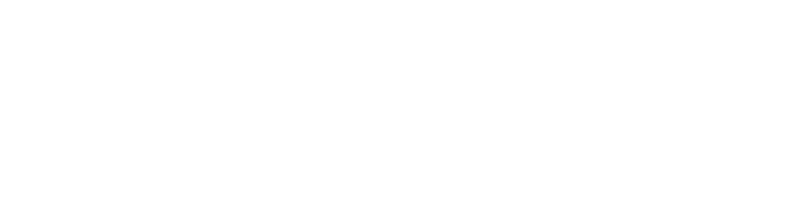

In [38]:
n_cols=4
mols = [Chem.MolFromSmiles(smile) for smile in new_smiles]
Draw.MolsToGridImage(mols, molsPerRow=n_cols, subImgSize=(200, 200))